# Evaluate trained models

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import matplotlib

import pred_spot_intensity.evaluation_utils as evaluation_utils

# plt.style.use('dark_background')
plt.style.use('default')

### 1. Specify task to evaluate (to be updated update)
Specify which task to evaluate: `detection_per_mol_sum` or `regression_on_detected_per_mol_sum`

In [25]:
# TASK_NAME = "detection_per_mol_sum"
TASK_NAME = "regression_on_detected_per_mol_sum"

# Name of the experiment where to find the training predictions (by default in `training_results/paper_results`):
EXP_NAME = "paper_results"

### 2. Import training predictions and compute scores

In [26]:
plots_dir = Path.cwd() / "./plots" / EXP_NAME / TASK_NAME
plots_dir.mkdir(exist_ok=True, parents=True)
results_dir = Path.cwd() / "./training_results" / EXP_NAME / TASK_NAME
raw_intensities_csv = Path.cwd() / "./training_data/intensity_data_raw.csv"


In [30]:
OUR_MODEL_NAME = "NeuralNet"

selected_model = "MLP"
plots_dir.mkdir(exist_ok=True, parents=True)

filenames = {
    OUR_MODEL_NAME: "results_mol_feat.csv",
    "Baseline": "results_random_feat.csv",
}

formatted_metric_names = {
    "macro_avg_f1_score": "Macro-Avg-F1 Score",
    "Spearman's R": "Spearman's R"
}

In [31]:
if "detection" in TASK_NAME:
    metric = "macro_avg_f1_score"
    count_key = 'detected'
    task_typename = "classification"
elif "regression" in TASK_NAME or "rank" in TASK_NAME:
    metric = "Spearman's R"
    count_key = 'non-zero obs'
    task_typename = "regression"
else:
    raise ValueError(TASK_NAME)



In [28]:
molecules_with_zero_charge = evaluation_utils.get_molecules_with_zero_formal_charge(raw_intensities_csv)

In [32]:
GLOBAL_STRING = r"\textbf{Global}"
# Compute the actual scores:
model_metrics, models_predictions, model_typename = evaluation_utils.compute_scores(filenames, TASK_NAME, task_typename,
                                                                                    eval_feat_selection=False,
                                                                                    has_multiple_iterations=True,
                                                                                    name_global_column=GLOBAL_STRING,
                                                                                    molecules_with_zero_charge=molecules_with_zero_charge,
                                                                                    results_dir=results_dir)


In [34]:
index_columns = ["matrix", "polarity", "train_setup", "model_type", "adduct_setup"]

# Take avg and std over multiple iterations:
std_metrics = model_metrics.groupby(index_columns, as_index=True).std().drop(columns="iter_index")
mean_metrics = model_metrics.groupby(index_columns, as_index=True).mean().drop(columns="iter_index")
mean_metrics = mean_metrics.join(std_metrics, lsuffix='_mean', rsuffix='_std').reset_index()

### 3. Plot the achieved scores
By default, plots will be saved in the directory `./plots/<EXP_NAME>/<TASK_NAME>`

In [35]:
ecolors = [
    'lightgreen',
    'lightcoral',
    'lightblue'
]

dot_colors = [
    'black',
    'black',
    'black',
    # 'orange',
    # 'mediumpurple',
    # 'blue',
]

global_labels = {
    "": "All",
    "positive": "Positive",
    "negative": "Negative"
}

polarity_labels = {
    "positive": "Positive",
    "negative": "Negative"
}


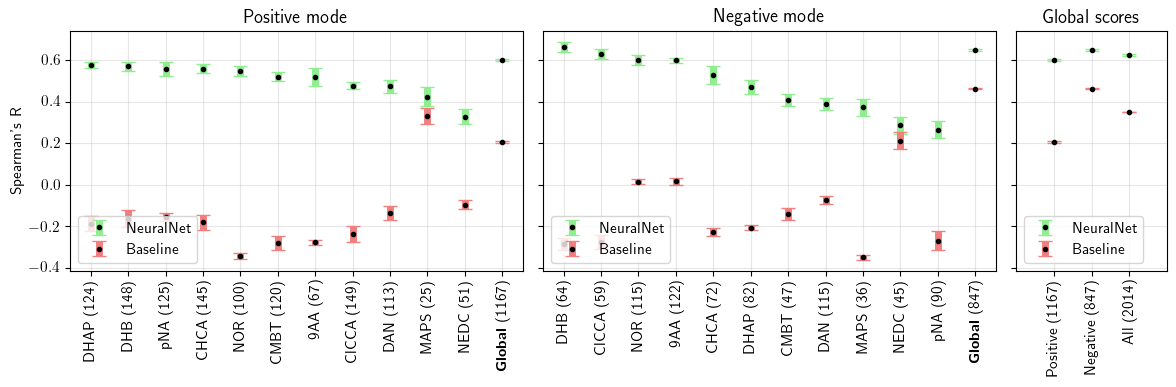

In [36]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4),
                         sharey=True,
                         gridspec_kw={'width_ratios': [3, 3, 1]})
axes = np.array([axes])

error_bars_kwargs = {"linestyle": "none",
                     "elinewidth": 5,
                     "capsize": 5,
                     "fmt": '.'
                     }

plt.xticks(rotation='vertical')
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=11)
    # ax.set_xticks(rotation='vertical')

for pol_idx, polarity in enumerate(["positive", "negative"]):
    ax = axes[0, pol_idx]
    filtered_metrics = mean_metrics[mean_metrics.polarity == polarity].sort_values(metric + '_mean', ascending=False)
    # print(f"Plot results for task {TASK_NAME}:")
    # plt.rcParams.update({'font.size': 16})
    # mean_metrics["Matrix (polarity)"] = mean_metrics["matrix"] + " (" + mean_metrics["polarity"] + ")"

    # fig.tight_layout(h_pad=3, w_pad=2)
    # fig.savefig(plots_dir / f"{task_typename}_global_plot.pdf")
    #
    sorted_matrices = filtered_metrics[filtered_metrics.train_setup == OUR_MODEL_NAME].sort_values(
        metric + '_mean', ascending=False).matrix.reset_index(drop=True)
    # Move the global score at the end:
    target_row = sorted_matrices[sorted_matrices == GLOBAL_STRING].index.item()
    idx = [i for i in range(len(sorted_matrices)) if i != target_row] + [target_row]
    sorted_matrices = sorted_matrices.iloc[idx]
    # print(sorted_matrices)

    filtered_metrics = filtered_metrics.sort_values('train_setup', ascending=False)
    for i, (train_setup, rows) in enumerate(filtered_metrics.groupby("train_setup", sort=False)):
        # print(rows)
        df_to_plot = rows.set_index("matrix", drop=True).loc[sorted_matrices]
        if task_typename == "regression":
            x_labels = pd.Series(
                sorted_matrices.astype("str").to_numpy() + " (" + df_to_plot["non-zero obs_mean"].astype("int").astype(
                    "str").to_numpy() + ")",
                index=sorted_matrices.index)
        else:
            x_labels = sorted_matrices

        ax.errorbar(x_labels.to_numpy(), df_to_plot[metric + '_mean'].to_numpy(),
                    yerr=df_to_plot[metric + '_std'].to_numpy(),
                    color=dot_colors[i], ecolor=ecolors[i],
                    label=train_setup, **error_bars_kwargs)
        # # Add a line separating the global results:
        # ax.axvline(x=10.5)

    # mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
    ax.legend(loc="lower left")
    if pol_idx == 0:
        ax.set_ylabel(formatted_metric_names[metric])
    # ax.set_xlabel("Matrix type")
    # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3,
            # axis='y'
            )
    ax.set_title(f"{polarity_labels[polarity]} mode")
    plt.sca(ax)
    plt.xticks(rotation=90)

# ----------------------
# Global scores, plot scores:
# ----------------------
ax = axes[0, 2]
filtered_metrics = mean_metrics[mean_metrics.matrix == GLOBAL_STRING].sort_values(metric + '_mean', ascending=False)
x_labels = pd.Series([global_labels[pol] for pol in filtered_metrics["polarity"]]).astype("str")
if task_typename == "regression":
    x_labels = x_labels.to_numpy() + " (" + filtered_metrics["non-zero obs_mean"].astype("int").astype(
        "str").to_numpy() + ")"
else:
    x_labels = x_labels.to_numpy()
filtered_metrics["Matrix and polarity"] = pd.Series(x_labels, index=filtered_metrics.index)
# filtered_metrics["Matrix and polarity"] = filtered_metrics["polarity"] + " polarity"
# filtered_metrics.loc[filtered_metrics.polarity == "", "Matrix and polarity"] = "All matrices"
# print(f"Plot results for task {TASK_NAME}:")

filtered_metrics = filtered_metrics.sort_values("Matrix and polarity", ascending=False)

for i, (train_setup, rows) in enumerate(filtered_metrics.groupby("train_setup", sort=False)):
    # print(train_setup)
    # df_to_plot = rows.set_index("matrix", drop=True).loc[sorted_matrices]
    # if task_typename == "regression":
    #     x_labels =  pd.Series(sorted_matrices.astype("str").to_numpy() + "(" + df_to_plot["non-zero obs_mean"].astype("int").astype("str").to_numpy() + ")",
    #                                 index=sorted_matrices.index)
    # else:
    #     x_labels = sorted_matrices

    # ax.errorbar(x_labels.to_numpy(), df_to_plot[metric + '_mean'].to_numpy(), yerr=df_to_plot[metric+'_std'].to_numpy(),
    #             color = dot_colors[i], ecolor = ecolors[i],
    #           label=train_setup, **error_bars_kwargs)

    p = ax.errorbar("Matrix and polarity", metric + '_mean', yerr=metric + '_std', data=rows,
                    color=dot_colors[i], ecolor=ecolors[i],
                    label=train_setup, **error_bars_kwargs)
    # # Add a line separating the global results:
    # ax.axvline(x=10.5)

# mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
ax.legend(loc="lower left")
# ax.set_ylabel(formatted_metric_names[metric])

# ax.set_xlabel("Matrix type")
# ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
# ylims = [0.3, 0.8]
# ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.05, 0.05))
ax.grid(visible=True, alpha=0.3,
        # axis='y'
        )
ax.set_xlim(-1, 3)
ax.set_title("Global scores")
plt.sca(ax)
plt.xticks(rotation=90)

# axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,1])
# axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,2])

# axes[1,0].get_shared_y_axes().join(axes[1,0], axes[1,1])
# axes[1,0].get_shared_y_axes().join(axes[1,0], axes[1,2])


fig.tight_layout(h_pad=2, w_pad=1)
fig.savefig(plots_dir / f"{task_typename}_scores.pdf")
